# Análisis de Cohortes para Fees

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Mounted at /content/drive


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv']

In [ ]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')
# Crear una copia del DataFrame para preservar el original
fs = fees.copy()
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


In [ ]:
# Filtrar columnas relevantes para el análisis
fs = fs[["cash_request_id", "total_amount", "created_at"]]
fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cash_request_id  21057 non-null  float64
 1   total_amount     21061 non-null  float64
 2   created_at       21061 non-null  object 
dtypes: float64(2), object(1)
memory usage: 493.7+ KB


In [ ]:
# Convertir la columna 'created_at' en fees a tipo datetime para análisis temporal
fs['created_at'] = pd.to_datetime(fs['created_at'])
fs.head()

,cash_request_id,total_amount,created_at
0,14941.0,5.0,2020-09-07 10:47:27.423150+00:00
1,11714.0,5.0,2020-09-09 20:51:17.998653+00:00
2,23371.0,5.0,2020-10-23 10:10:58.352972+00:00
3,26772.0,5.0,2020-10-31 15:46:53.643958+00:00
4,19350.0,5.0,2020-10-06 08:20:17.170432+00:00


In [ ]:
 # Convertir la columna 'created_at' a una fecha sin zona horaria
fs['created_at'] = fs['created_at'].dt.tz_localize(None)
fs.head()

,cash_request_id,total_amount,created_at
0,14941.0,5.0,2020-09-07 10:47:27.423150
1,11714.0,5.0,2020-09-09 20:51:17.998653
2,23371.0,5.0,2020-10-23 10:10:58.352972
3,26772.0,5.0,2020-10-31 15:46:53.643958
4,19350.0,5.0,2020-10-06 08:20:17.170432


In [ ]:
# Crear columna 'Mes' indicando el mes de cada solicitud
fs['Mes'] = fs['created_at'].dt.to_period('M')
fs.head()

,cash_request_id,total_amount,created_at,Mes
0,14941.0,5.0,2020-09-07 10:47:27.423150,2020-09
1,11714.0,5.0,2020-09-09 20:51:17.998653,2020-09
2,23371.0,5.0,2020-10-23 10:10:58.352972,2020-10
3,26772.0,5.0,2020-10-31 15:46:53.643958,2020-10
4,19350.0,5.0,2020-10-06 08:20:17.170432,2020-10


In [ ]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
fs['Cohorte'] = fs.groupby('cash_request_id')['created_at'].transform('min').dt.to_period('M')
fs.head(10)

,cash_request_id,total_amount,created_at,Mes,Cohorte
0,14941.0,5.0,2020-09-07 10:47:27.423150,2020-09,2020-09
1,11714.0,5.0,2020-09-09 20:51:17.998653,2020-09,2020-08
2,23371.0,5.0,2020-10-23 10:10:58.352972,2020-10,2020-10
3,26772.0,5.0,2020-10-31 15:46:53.643958,2020-10,2020-10
4,19350.0,5.0,2020-10-06 08:20:17.170432,2020-10,2020-10
5,24052.0,5.0,2020-10-24 12:22:27.666102,2020-10,2020-10
6,25983.0,5.0,2020-10-30 04:38:06.826149,2020-10,2020-10
7,14839.0,5.0,2020-10-16 23:48:50.655967,2020-10,2020-09
8,26572.0,5.0,2020-10-31 05:29:08.471800,2020-10,2020-10
9,22106.0,5.0,2020-10-21 08:48:50.696961,2020-10,2020-10


In [ ]:
# Calcular la cantidad de tarifas iniciales por cohorte
cohort_fees_initial = fs.groupby('Cohorte').agg(Num_Tarifas_Iniciales=('cash_request_id', 'nunique')).reset_index()
cohort_fees_initial

,Cohorte,Num_Tarifas_Iniciales
0,2020-05,14
1,2020-06,447
2,2020-07,856
3,2020-08,1922
4,2020-09,2640
5,2020-10,6930
6,2020-11,124


In [ ]:
# Calcular el número de tarifas en cada cohorte para cada mes
cohort_fees_monthly = fs.groupby(['Cohorte', 'Mes']).agg(Num_Tarifas=('cash_request_id', 'nunique')).reset_index()
cohort_fees_monthly

,Cohorte,Mes,Num_Tarifas
0,2020-05,2020-05,14
1,2020-05,2020-06,5
2,2020-05,2020-07,2
3,2020-05,2020-08,1
4,2020-05,2020-09,1
5,2020-05,2020-10,1
6,2020-06,2020-06,447
7,2020-06,2020-07,196
8,2020-06,2020-08,74
9,2020-06,2020-09,42


In [ ]:
# Calcular la tasa de retención de tarifas (número de tarifas de cada cohorte en cada mes / tarifas iniciales de la cohorte)
retention_fees = cohort_fees_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Tarifas')
retention_fees = retention_fees.div(cohort_fees_initial.set_index('Cohorte')['Num_Tarifas_Iniciales'], axis=0)
retention_fees

Mes,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,
2020-05,1.0,0.357143,0.142857,0.071429,0.071429,0.071429,NaN
2020-06,NaN,1.000000,0.438479,0.165548,0.093960,0.082774,NaN
2020-07,NaN,NaN,1.000000,0.371495,0.200935,0.143692,NaN
2020-08,NaN,NaN,NaN,1.000000,0.356400,0.197190,NaN
2020-09,NaN,NaN,NaN,NaN,1.000000,0.360985,0.006439
2020-10,NaN,NaN,NaN,NaN,NaN,1.000000,0.014286
2020-11,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


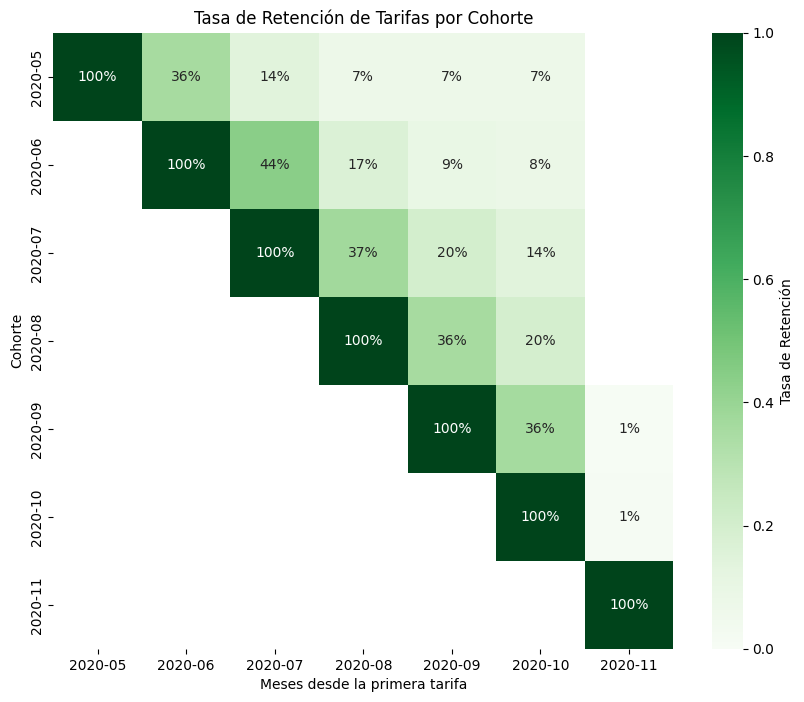

In [ ]:
# Visualizar la tasa de retención de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Tarifas por Cohorte')
sns.heatmap(data=retention_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Greens', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()

In [ ]:
# Calcular la tasa de abandono de tarifas (1- tasa de retención de tarifas)
churn_fees = 1- retention_fees

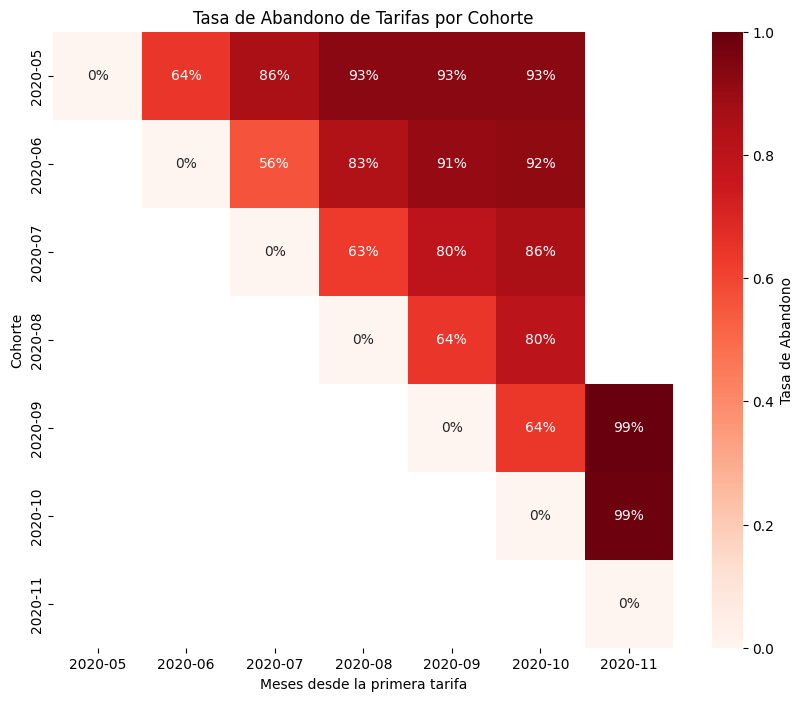

In [ ]:
# Visualizar la tasa de abandono de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Tarifas por Cohorte')
sns.heatmap(data=churn_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='Reds', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()